# Install Packages for DietVision

In [42]:
import sys
!{sys.executable} -m pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision matplotlib
!{sys.executable} -m pip install -q segment-anything gradio datasets transformers torch torchvision numpy Pillow


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [85]:
import sys
!{sys.executable} -m pip -q install IPython


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


# Set up GPU and create a Mask Generator

In [2]:
import os
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

HOME = os.getcwd() # /apps

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = 'vit_h'

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Generate masks of a test image

In [3]:
import cv2
import numpy as np

IMAGE_NAME = 'fish_chips.jpg'
IMAGE_DIRECTORY = os.path.join(HOME, 'images')
IMAGE_PATH = os.path.join(IMAGE_DIRECTORY, IMAGE_NAME)

image_bgr = cv2.imread(IMAGE_PATH) # np.ndarray
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # np.ndarray

sam_result = mask_generator.generate(image_rgb)

In [9]:
from PIL import Image
import supervision as sv

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(sam_result=sam_result)
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
masks = [mask['segmentation'] for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)]

In [6]:
h, w = masks[0].shape
mask_dictionary = np.full((h, w), -1)

In [116]:
from matplotlib import pyplot as plt
import random

def plot_image_by_ndarray(nda: np.ndarray):
    plt.imshow(nda)
    plt.show()

def spot_annotator(index: int) -> np.ndarray:
    cp = sv.ColorPalette.default()
    idx = random.choice(range(len(cp.colors)))

    img = image_rgb.copy()
    colored_mask = np.zeros_like(img, dtype=np.uint8)
    colored_mask[:] = cp.by_idx(idx).as_bgr()

    opacity: float = 0.5

    return np.where(
        np.expand_dims(masks[index],axis=-1),
        np.uint8(opacity*colored_mask + (1-opacity)*img), 
        img,
    )

def spot_annotator_on_mask(index: int) -> np.ndarray:
    cp = sv.ColorPalette.default()
    idx = random.choice(range(len(cp.colors)))

    img = cv2.imread('../apps/images/blank_transparent_image.png')
    colored_mask = np.zeros_like(img, dtype=np.uint8)
    colored_mask[:] = cp.by_idx(idx).as_bgr()

    opacity: float = 0.5

    return np.where(
        np.expand_dims(masks[index],axis=-1),
        np.uint8(opacity*colored_mask + (1-opacity)*img), 
        img,
    )

def init_mask_dictionary(ms: np.ndarray, md: np.ndarray):
    for mi in range(len(ms)):
        mask = ms[mi]
        for row in range(h): # y
            for col in range(w): # x
                if mask[row][col]:
                    if md[row][col] == -1:
                        md[row][col] = mi

def count_non_negative_spot(md: np.ndarray):
    count = 0

    for row in range(len(md)):
        for col in range(len(md[0])):
            if md[row][col] != -1:
                count += 1
    return count

def plot_annotation_grid(img1: np.ndarray, img2: np.ndarray, img1_title: str, img2_title: str):
    sv.plot_images_grid(
        images = [img1, img2],
        grid_size = (1, 2),
        titles = [img1_title, img2_title]
    )

def plot_masks_grid(masks: list):
    sv.plot_images_grid(
        images=masks,
        grid_size =(16, int(len(masks) / 6)),
        size=(16, 16)
    )

def combine_masks(m1, m2, combine_mask_path):
    mask1 = cv2.imread(m1)
    mask2 = cv2.imread(m2)

    merged_masks = cv2.bitwise_or(mask1, mask2)
    merged_masks = Image.fromarray(merged_masks)
    merged_masks.save(combine_mask_path)

In [120]:
diet_vision_data = [{
    'mask': mask['segmentation'],
    'area': mask['area'],
    'class': None,
    'redirect': -1,
} for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)]

DIET_VISION_DICTIONARY = {}

for idx, m in enumerate(diet_vision_data):
    DIET_VISION_DICTIONARY.update({ idx: m })

# Create a blank transparent image

In [63]:
blank_white_image = 255 * np.ones((h, w, 3), dtype = np.uint8)
im_rgba = Image.fromarray(blank_white_image).convert('RGBA')
im_rgba_data = im_rgba.getdata()
im_rgba_new_data = []

for item in im_rgba_data:
    if item[0] == 255 and item[1] == 255 and item[2] == 255:
        im_rgba_new_data.append((255, 255, 255, 0))
    else:
        im_rgba_new_data.append(item)

im_rgba.putdata(im_rgba_new_data)
im_rgba.save('../apps/images/blank_transparent_image.png', "PNG")

In [124]:
transparent_image_test = cv2.imread('../apps/images/blank_transparent_image.png')
annotated_mask_test = spot_annotator_on_mask(1)

img1_test = Image.fromarray(transparent_image_test).convert('RGBA')
img2_test = Image.fromarray(annotated_mask_test).convert('RGBA')

img_test_new_data = []

count = 0

for item in img2_test.getdata():
    if item[0] == 255 and item[1] == 255 and item[2] == 255:
        img_test_new_data.append((255, 255, 255, 0))
    else:
        a, b, c, _ = item
        img_test_new_data.append((a, b, c, 127))

# print(np.array(img_test_new_data).shape)
img1_test.putdata(img_test_new_data)
img1_test.save('../apps/images/test_test.png', "PNG")
# 5018112

# Separator

In [39]:
img1 = cv2.imread(IMAGE_PATH)
img2 = cv2.imread('../docs/images/1_mask_fish_chips.jpg', 0)
img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY)[1]
img1[img2 == 0] = (36, 255, 12)
cv2.imshow('img1', img1)

In [ ]:
init_mask_dictionary(masks, mask_dictionary)

print(f'diff: {(h*w)-count_non_negative_spot(mask_dictionary)}') # diff: 171412
print(f'total pixel: {h*w}') # total pixel: 5018112

print(masks[0][100][100])
print(mask_dictionary[1074][1725])

In [ ]:
blank_white_image = 255 * np.ones((h, w, 3), dtype = np.uint8)
transparent_image = Image.open('../apps/images/blank_transparent_image.png')
print(np.array(transparent_image).shape)
transparent_image_copy = transparent_image.copy()
transparent_image_copy = transparent_image_copy.convert('RGB') # -> Image
transparent_image_copy = np.array(transparent_image_copy)

def spot_annotator2(index: int) -> np.ndarray:
    cp = sv.ColorPalette.default()
    idx = random.choice(range(len(cp.colors)))

    img = image_rgb.copy()
    colored_mask = np.zeros_like(img, dtype=np.uint8)
    colored_mask[:] = cp.by_idx(idx).as_bgr()
    opacity: float = 0.5

    return np.where(
        np.expand_dims(masks[index], axis=-1),
        np.uint8(colored_mask),
        transparent_image_copy,
    )

# rgba = cv2.cvtColor(spot_annotator2(1), cv2.COLOR_RGB2RGBA)
# Image.fromarray(rgba).show()
# rgba = Image.fromarray(rgba[:,:,3])
# cv2.imwrite('../apps/images/test_transparent.jpg', rgba)
# plot_image_by_ndarray(spot_annotator2(1))
arr = spot_annotator2(1)

In [168]:
blank_white_image_data = Image.fromarray(blank_white_image)
blank_white_image_data.save('../apps/images/blank_white_image.jpg')

In [269]:
from PIL import Image

img11 = Image.open(IMAGE_PATH)
img22 = Image.open('../apps/images/test_test.png')

img11.paste(img22)
img11.show()

In [ ]:
tic = cv2.imread('../apps/images/blank_transparent_image3.png')
red = 255 * np.ones(tic.shape)
img_copy = image_rgb.copy()
img_copy[:,:,0][tic > 0] = red[tic > 0]
img_copy.save('../apps/image/test.png', 'PNG')

In [ ]:
import cv2

im = cv2.imread(IMAGE_PATH)
h, w, c = im.shape # 1936 2592 3

mask_borders = [ mask['bbox'] for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True) ]

IMAGE_SEGMENTATION = {}

content_img = f'<img src="{IMAGE_GIT_URL}" width="{w}" height="{h}" usemap="#image-map">'
content_map = '<map name="image-map">'

sorted_sam_result = sorted(sam_result, key=lambda x: x['area'], reverse=True)

for key_index, value in enumerate(sorted_sam_result):
  ssr = value

  area = ssr['area']
  bbox = ssr['bbox']
  mask = ssr['segmentation']

  index_unmask_image_name = get_unmask_image_name(key_index)
  generate_image_from_mask(mask, key_index)
  object_class = classify(index_unmask_image_name)

  IMAGE_SEGMENTATION[key_index] = dict(area = area, bbox = bbox, mask = mask, prediction=object_class)

  coords = ','.join(map(str, bbox))

  content_map += f'<area target="" alt="{index_unmask_image_name}" title="{object_class}" href="/" coords="{coords}" shape="poly">'

content_map += '</map>'

In [ ]:
import os
import IPython

content_script = """
  var images = document.querySelectorAll('img[usemap]');
        images.forEach( function(image) {
            var mapid = image.getAttribute('usemap').substr(1);
            var imagewidth = image.getAttribute('width');
            var imageheight = image.getAttribute('height');
            var imagemap = document.querySelector('map[name="'+mapid+'"]');
            var areas = imagemap.querySelectorAll('area');

            image.removeAttribute('usemap');
            imagemap.remove();

            // create wrapper container
            var wrapper = document.createElement('div');
            wrapper.classList.add('imagemap');
            image.parentNode.insertBefore(wrapper, image);
            wrapper.appendChild(image);

            areas.forEach( function(area) {
                var coordsAttributes = area.getAttribute('coords').split(' ').join('');
                var coords = coordsAttributes.split(',');
                var xcoords = [parseInt(coords[0]),parseInt(coords[0])+parseInt(coords[2])];
                var ycoords = [parseInt(coords[1]),parseInt(coords[1])+parseInt(coords[3])];
                xcoords = xcoords.sort(function(a, b){return a-b});
                ycoords = ycoords.sort(function(a, b){return a-b});
                wrapper.innerHTML += "<a href='"+area.getAttribute('href')+"' title='"+area.getAttribute('title')+"' class='area' style='left: "+((xcoords[0]/imagewidth)*100).toFixed(2)+"%; top: "+((ycoords[0]/imageheight)*100).toFixed(2)+"%; width: "+(((xcoords[1] - xcoords[0])/imagewidth)*100).toFixed(2)+"%; height: "+(((ycoords[1] - ycoords[0])/imageheight)*100).toFixed(2)+"%;'></a>";
            });
        });
"""

content_style = """
  img {max-width: 100%; height: auto;}
  .imagemap {position: relative;}
  .imagemap img {display: block;}
  .imagemap .area {display: block; position: absolute; transition: box-shadow 0.15s ease-in-out;}
  .imagemap .area:hover {box-shadow: 0px 0px 1vw rgba(0,0,0,0.5);}
"""

IPython.display.HTML('''
    <!DOCTYPE html>
    <html>
      <script>
        {content_script}
      </script>
      <style>
        {content_style}
      </style>
      <body>
        {content_img}
        {content_map}
      </body>
    </html>
'''.format(
    content_script=content_script,
    content_style=content_style,
    content_map=content_map,
    content_img=content_img
))

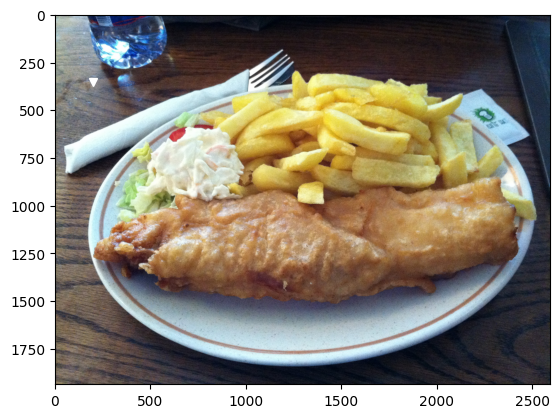

In [ ]:
from matplotlib import image
from matplotlib import pyplot as plt

def plot_image(image_path):
  # to read the image stored in the working directory
  data = image.imread(image_path)

  # to draw a point on co-ordinate (200,300)
  plt.plot(200, 350, marker='v', color="white")
  plt.imshow(data)
  plt.show()

# Mask to Image

In [ ]:
import matplotlib.pyplot as plt

def get_unmask_image_name(mask_index, image_name):
  return os.path.join(HOME, 'data', f'{mask_index}_unmask_{image_name}')

def get_mask_image_name(mask_index, image_name):
  return os.path.join(HOME, 'data', f'{mask_index}_mask_{image_name}')

def generate_image_from_mask(mask_by_sam, mask_index):
  mask_image_path   = get_mask_image_name(mask_index)
  unmask_image_path = get_unmask_image_name(mask_index)

  data = Image.fromarray(mask_by_sam)
  data.save(mask_image_path)

  img = cv2.imread(IMAGE_PATH)
  mask = cv2.imread(mask_image_path, 0)

  res = cv2.bitwise_and(img, img, mask = mask)
  res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB) # cv2.COLOR_BGR2GRAY

  data = Image.fromarray(res)
  data.save(unmask_image_path)

# deprecated
def generate_image_from_mask_batch():
  MASK_RANGE = range(len(masks))

  for mask_index in MASK_RANGE:
    if mask_index == 90:
      mask_image_path = os.path.join(HOME, "data", f'{mask_index}_mask_{IMAGE_NAME}')
      data = Image.fromarray(masks[mask_index])
      data.save(mask_image_path)

      img = cv2.imread(IMAGE_PATH)
      mask = cv2.imread(mask_image_path, 0)
      res = cv2.bitwise_and(img, img, mask = mask)
      res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB) # cv2.COLOR_BGR2GRAY

      data = Image.fromarray(res)
      data.save(f'{mask_index}_unmask_{IMAGE_NAME}')

In [ ]:
import gradio as gr

row_range = range(1)

def launch_demo():
  with gr.Blocks() as demo:
      with gr.Row():
        for mask_index in row_range:
          gr.Image(get_unmask_image_name(mask_index), scale=1)

      gr.Dropdown(["chocolate cake", "ramen", "sushi"], label="Food 101", info="Select one"),

  demo.launch()

# Classification

In [ ]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import torch
import numpy as np
from PIL import Image

def setup():
  global processor, clip_labels, model, labels, imagenette

  image_path = IMAGE_PATH
  # show dataset info
  imagenette = load_dataset('food101')

  labels = imagenette['train'].features['label'].names

  # generate sentences
  clip_labels = [f"a photo of a {label}" for label in labels]

  # initialization
  model_id = "openai/clip-vit-base-patch32"

  processor = CLIPProcessor.from_pretrained(model_id)
  model = CLIPModel.from_pretrained(model_id)

def classify(image_path):
  # create label tokens
  label_tokens = processor(
      text=clip_labels,
      padding=True,
      images=None,
      return_tensors='pt'
  ).to(DEVICE)

  # encode tokens to sentence embeddings
  label_emb = model.to(DEVICE).get_text_features(**label_tokens)

  # detach from pytorch gradient computation
  label_emb = label_emb.detach().cpu().numpy()

  # normalization
  label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
  # image_path = os.path.join(HOME, image_path)

  image = processor(
      text=None,
      images=Image.open(image_path),
      return_tensors='pt'
  )['pixel_values'].to(DEVICE)

  img_emb = model.get_image_features(image)
  img_emb = img_emb.detach().cpu().numpy()
  scores = np.dot(img_emb, label_emb.T)
  pred = np.argmax(scores)

  return labels[pred]

In [121]:
import IPython


IPython.display.HTML('''
    <!DOCTYPE html>
    <html>
      <style>
        .image1 {
            position: absolute;
            top: 25px;
            left: 25px;
            border: 1px solid #000000;
            z-index: 1;
        }
        .image2 {
            position: absolute;
            top: 25px;
            left: 25px;
            border: 1px solid #000000;
            z-index: 2;
        }
      </style>
      <body>
        <img class="image1" src="http://raw.githubusercontent.com/euijae/nyu_diet_vision/main/apps/images/fish_chips.jpg" />
        <img class="image2" src="http://raw.githubusercontent.com/euijae/nyu_diet_vision/main/apps/images/fish_chips.jpg" />
      </body>
    </html>
''')